In [1]:
from __future__ import division, print_function, absolute_import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
ethnea_df = pd.read_csv('names_ethnea_genni_country_sample.csv')
ethnea_df.head()

,AUID,Last,First,Ethnea,Genni,PubCountry
0,12872768_1,_Filho_,_Elias_Abdalla_,HISPANIC,M,Brazil
1,12565879_3,_Bou_Abdallah_,_Jad_,ARAB,M,France
2,17569133_1,_Abdel_Aziz_,_Ayman_,ARAB,M,USA
3,11213157_2,_Abdelmoula_,_Salma_,ARAB,F,Tunisia
4,11439058_1,_Abdou_,_Ibrahim_,ARAB,M,Egypt


In [3]:
# First thing first, use the character feature for making the dnn model
def extract_structure(word,n_char=2):
    x_struct = []
    word_len = len(word) + n_char
    n_char-=1
    counter = 0
    for i in range(word_len):
        end = i+1
        start = (i - n_char) if (i - n_char) > 0 else 0
        if word[start:end]!='_' and word[start:end]!='':
        #if word[start:end]!='_':
            x_struct.append(word[start:end])
    return x_struct

first_name_struct = ethnea_df.First.apply(lambda x: extract_structure(x.lower(),3))
last_name_struct = ethnea_df.Last.apply(lambda x: extract_structure(x.lower(),3))

In [4]:
first_name_struct.head()

0    [_e, _el, eli, lia, ias, as_, s_a, _ab, abd, b...
1                              [_j, _ja, jad, ad_, d_]
2                    [_a, _ay, aym, yma, man, an_, n_]
3                    [_s, _sa, sal, alm, lma, ma_, a_]
4          [_i, _ib, ibr, bra, rah, ahi, him, im_, m_]
Name: First, dtype: object

In [5]:
# make struct dictionary
struct_dict = {}
for name_struct_i in first_name_struct:
    for struct_j in name_struct_i:
        if struct_j not in struct_dict:
            struct_dict[struct_j]=0
        struct_dict[struct_j]+=1
for name_struct_i in last_name_struct:
    for struct_j in name_struct_i:
        if struct_j not in struct_dict:
            struct_dict[struct_j]=0
        struct_dict[struct_j]+=1

In [6]:
struct_dict_keys = list(struct_dict.keys())
ethnic_series = ethnea_df['Ethnea'].str.lower()
ethnic_keys = list(np.unique(ethnic_series.values))

In [7]:
# load test train data
with open('train_test_fix_index.pickle', 'rb') as f:
    trainIndex,testIndex,trainX,trainY,testX,testY,ethnic_keys,tmp = pickle.load(f)

In [8]:
def transform_structure(name_struct):
    list_structure = []
    for x in name_struct:
        try:
            list_structure.append(struct_dict_keys.index(x)+1)
        except BaseException:
            list_structure.append(0)
    #add pading 0 for structure less than num_input
    #for i in range(len(list_structure),timesteps):
    #    list_structure.append(0)
    return list_structure   
    #return [*map(lambda x:struct_dict_keys.index(x)+1, name_struct)]

#data_source = full_name_struct.apply(lambda x: transform_structure(x))

def generate_batch(first_name, last_name, i, batch_size=10000):
    len_name = len(first_name)
    start = i*batch_size
    end = start+batch_size if start+batch_size < len_name else len_name
    len_mat = end - start
    #first_name_ds_mat = np.zeros((len_mat,50),dtype=np.int32)
    #last_name_ds_mat = np.zeros((len_mat,50),dtype=np.int32)
    first_name_ds_mat = first_name[start:end]
    last_name_ds_mat = last_name[start:end]
    first_name_ds_mat = pad_sequences(first_name_ds_mat.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
    #first_name_ds_mat = first_name_ds_mat.reshape(first_name_ds_mat.shape[0],1,first_name_ds_mat.shape[1])
    last_name_ds_mat = pad_sequences(last_name_ds_mat.apply(lambda x:transform_structure(x)),maxlen=50,value=0.)
    #last_name_ds_mat = last_name_ds_mat.reshape(last_name_ds_mat.shape[0],1,last_name_ds_mat.shape[1])

    """
    for i in range(len_mat):
        x = first_name_struct.iloc[i]
        for y in x:
            first_name_ds_mat[i,struct_dict_keys.index(y)]+=1
        x = last_name_struct.iloc[i]
        for y in x:
            last_name_ds_mat[i,struct_dict_keys.index(y)]+=1
    """
    return first_name_ds_mat,last_name_ds_mat, range(start,end)


In [9]:
first_name_ds = first_name_struct.apply(lambda x:transform_structure(x))
last_name_ds = last_name_struct.apply(lambda x:transform_structure(x))

In [10]:
len(struct_dict_keys)

8626

In [12]:
first_name_ds

(44567,)

In [13]:
def transform_labels(x):
    y = np.zeros(len(ethnic_keys))
    y[ethnic_keys.index(x)]=1
    return y

labels = np.array(list(map(lambda x: transform_labels(x),ethnic_series)))

In [17]:
labels.shape

(44567, 23)

In [14]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tflearn.data_utils import to_categorical, pad_sequences



Using TensorFlow backend.


In [19]:
from keras.layers import Input
from keras.models import Model

seq_length = 50

embedding_vector_length = 500

model = Sequential()
model.add(Embedding(len(struct_dict_keys)+1,embedding_vector_length,input_length=seq_length))
model.add(Bidirectional(LSTM(seq_length,return_sequences=False)))
model.add(keras.layers.Dense(512,activation='relu'))
model.add(keras.layers.Dense(256,activation='relu'))
model.add(keras.layers.Dense(len(ethnic_keys),activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 500)           4313500   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               220400    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51712     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 23)                5911      
Total params: 4,722,851
Trainable params: 4,722,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#first_name_model.summary()
first_trainX = first_name_struct[trainIndex]
first_testX = first_name_struct[testIndex]
last_trainX = last_name_struct[trainIndex]
last_testX = last_name_struct[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex]

#trainX =np.array([to_categorical(x,nb_classes=len(struct_dict_keys)+1) for x in trainX])
#testX =np.array([to_categorical(x,nb_classes=len(struct_dict_keys)+1) for x in testX])

mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 10000

for x in range(500):
    for y in range(len_mini_batch):
        y_first_trainX, y_last_trainX, batch_range =  generate_batch(first_trainX,last_trainX,y,mini_batch_size)
        model.fit([y_first_trainX],trainY[batch_range],epochs=1,batch_size=batch_size)
    first_test_ds_mat = pad_sequences(first_testX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
    #first_test_ds_mat = first_test_ds_mat.reshape(first_test_ds_mat.shape[0],1,first_test_ds_mat.shape[1])
    scores = model.evaluate([first_test_ds_mat],testY,verbose=0)
    print("Accuracy: %.2f%%" %(scores[1]*100))

Epoch 1/1
35653/35653 [==============================] - 72s - loss: 3.1020 - acc: 0.2360     
Accuracy: 31.39%
Epoch 1/1
35653/35653 [==============================] - 70s - loss: 2.8319 - acc: 0.3261     
Accuracy: 31.39%
Epoch 1/1
35653/35653 [==============================] - 70s - loss: 2.5093 - acc: 0.3261     
Accuracy: 31.39%
Epoch 1/1
35653/35653 [==============================] - 70s - loss: 2.3436 - acc: 0.3298     
Accuracy: 32.41%
Epoch 1/1
35653/35653 [==============================] - 70s - loss: 2.2456 - acc: 0.3328     
Accuracy: 32.74%
Epoch 1/1
35653/35653 [==============================] - 70s - loss: 2.1271 - acc: 0.3722     
Accuracy: 41.42%
Epoch 1/1
35653/35653 [==============================] - 70s - loss: 1.9718 - acc: 0.4246     
Accuracy: 41.54%
Epoch 1/1
35653/35653 [==============================] - 70s - loss: 1.8401 - acc: 0.4431     
Accuracy: 47.82%
Epoch 1/1
35653/35653 [==============================] - 70s - loss: 1.7083 - acc: 0.5108     
Accuracy:

In [ ]:
plt.hist([ethnic_keys.index(x) for x in ethnic_series.iloc[trainIndex]],normed=True)

In [43]:
def trans_name(name):
    name = name.lower()
    # transform space into underscore
    name = '_'+name.replace(' ','_')+'_'
    #transform the name into sequence structure
    ext_name = extract_structure(name)
    trans_name = transform_structure(ext_name)
    name_ds_mat = np.zeros((1,len(struct_dict_keys)),dtype=np.int32)
    for i,x in enumerate(trans_name):
        name_ds_mat[0,x-1]+=1
    #trans_name = pad_sequences([trans_name], maxlen=50,value=0.)
    return name_ds_mat

def predict_ethnicity(fname,lname):
    # lower case the name
    fnamex = trans_name(fname)
    lnamex = trans_name(lname)
    pred = loaded_model.predict([np.array(fnamex),np.array(lnamex)])
    pred_class = np.argsort(pred[0])[::-1]
    return_item = []
    for x in np.argsort(pred[0])[::-1]:
        return_item.append((ethnic_keys[x],pred[0][x]))
    return return_item

In [46]:
predict_ethnicity('Nikolos','Parulian')
#trans_name('Nikolaus')

[('greek', 0.91565043),
 ('hungarian', 0.039968226),
 ('african', 0.023328489),
 ('slav', 0.010720924),
 ('indian', 0.0044353865),
 ('french', 0.0028390423),
 ('romanian', 0.0013519992),
 ('hispanic', 0.0004805655),
 ('thai', 0.00040867552),
 ('israeli', 0.00022244373),
 ('baltic', 0.00021845232),
 ('indonesian', 0.00018888297),
 ('english', 0.00010734182),
 ('arab', 3.247691e-05),
 ('german', 2.0127121e-05),
 ('chinese', 1.9129955e-05),
 ('nordic', 4.1004869e-06),
 ('vietnamese', 2.4460342e-06),
 ('japanese', 3.6401113e-07),
 ('italian', 2.9021831e-07),
 ('dutch', 1.8433187e-07),
 ('korean', 9.6126428e-08),
 ('turkish', 7.3804962e-08)]

In [8]:
# embedd the structure vocabulary using text embedding and reduce the dimensionality

# convert the names into word structure vector
struct_dict_keys = list(struct_dict.keys())

def transform_structure(name_struct):
    list_structure = []
    for x in name_struct:
        try:
            list_structure.append(struct_dict_keys.index(x)+1)
        except BaseException:
            list_structure.append(0)
    #add pading 0 for structure less than num_input
    #for i in range(len(list_structure),timesteps):
    #    list_structure.append(0)
    return list_structure   
    #return [*map(lambda x:struct_dict_keys.index(x)+1, name_struct)]

#data_source = full_name_struct.apply(lambda x: transform_structure(x))

In [9]:
def transform_labels(x):
    y = np.zeros(len(ethnic_keys))
    y[ethnic_keys.index(x)]=1
    return y

labels = np.array(list(map(lambda x: transform_labels(x),ethnic_series)))

In [26]:
# using tflearn make the graph creation simple
import tensorflow as tf
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences
from sklearn.model_selection import train_test_split

# separate train and training set
trainX, testX, trainY, testY = train_test_split(data_source,[ethnic_keys.index(x) for x in ethnic_series],test_size = 0.2)

trainX = pad_sequences(trainX, maxlen=50,value=0.)
testX = pad_sequences(testX,maxlen=50,value=0.)
# Converting labels to binary vectors
trainY = to_categorical(trainY,nb_classes=len(ethnic_keys))
testY = to_categorical(testY,nb_classes=len(ethnic_keys))    

In [16]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import pickle

with open('train_test_fix.pickle', 'rb') as f:
    trainX,trainY,testX,testY,ethnic_keys,struct_dict_keys = pickle.load(f)
    #aha = pickle.load(f)

#with open('traintest-smote.pickle','rb') as f:
#    train_res,test_res = pickle.load(f)

with open('ethnic_keys.pickle','rb') as f:
    name_struct_keys,ethnic_keys = pickle.load(f)
        
embedding_vector_length = 1000
lstm_layer = 1000
max_sequence = 50

In [2]:
model = Sequential()
model.add(Embedding(len(name_struct_keys)+1,embedding_vector_length,input_length=max_sequence))
model.add(Conv1D(filters=embedding_vector_length,kernel_size=3,padding='same',activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(LSTM(lstm_layer,dropout=0.8))
model.add(Bidirectional(LSTM(max_sequence*2,return_sequences=False),input_shape=(max_sequence,1)))
#model.add(TimeDistributed(keras.layers.Dense(len(ethnic_keys),activation='softmax')))
model.add(keras.layers.Dense(len(ethnic_keys),activation='softmax'))
#model.add(keras.layers.Dense(len(ethnic_keys),activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())
for x in range(10):
    model.fit(trainX,trainY,epochs=1,batch_size=1000)
    scores = model.evaluate(testX,testY,verbose=0)
    print("Accuracy: %.2f%%" %(scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 1000)          62696000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 1000)          3001000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               880800    
_________________________________________________________________
dense_1 (Dense)              (None, 23)                4623      
Total params: 66,582,423
Trainable params: 66,582,423
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1
35653/35653 [==============================] - 778s - loss: 1.6879 - acc: 0.5265    
Accuracy: 75.88%
Epoch 1/1
35653/35653 [==============================] - 796s - loss: 0.5197 - acc: 0.8582    
Accuracy: 84.37%
Epoch 1/1
35653/35653 [==========

In [14]:
# load the model and f1 calculation

from keras.models import model_from_json
from keras import backend as K

# compute the accuracy
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2
    #print(precision)

    # How many relevant items are selected?
    recall = c1 / c3
    #print(recall)

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

def precision(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    return precision


def recall(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    recall = c1 / c3

    return recall

# load model
# load json and create model
json_file = open('model-keras-w3-bigram.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
#                               ,custom_objects= {'f1_score': f1_score})
loaded_model.load_weights("model-keras-w3-bigram-10.h5")

loaded_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',f1_score,precision,recall])

In [15]:
first_trainX = first_name_ds_mat[trainIndex]
first_testX = first_name_ds_mat[testIndex]
last_trainX = last_name_ds_mat[trainIndex]
last_testX = last_name_ds_mat[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex]


scores = loaded_model.evaluate([first_testX,last_testX],testY,verbose=0)

In [17]:
print('Accuracy: {}, F1: {}, Precision: {}, Recal: {}'.format(scores[1],scores[2],scores[3],scores[4]))

Accuracy: 0.8533767108053858, F1: 0.8554885642716294, Precision: 0.865419945870383, Recal: 0.8460848104239633


In [30]:
# make a confusion matrix
pred = loaded_model.predict([first_testX,last_testX])
# pred probability distribution

pred_class = np.array([np.argsort(x)[::-1][0] for x in pred])
test_labels = np.array([np.argsort(x)[::-1][0] for x in testY])
predicting_error = test_labels[np.where(pred_class != test_labels)]
class_error = pred_class[np.where(pred_class != test_labels)]

(array([    9.,    36.,    69.,   172.,   228.,   229.,   259.,   284.,
          438.,  7190.]),
 array([ 0.21,  0.29,  0.37,  0.45,  0.53,  0.61,  0.69,  0.76,  0.84,
         0.92,  1.  ]),
 <a list of 10 Patch objects>)

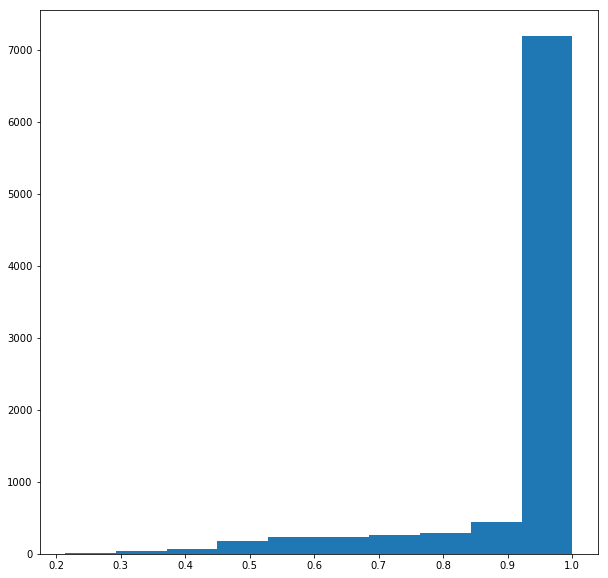

In [39]:
fig,ax = plt.subplots(figsize=(10,10))
ax.hist(np.array([x[np.argsort(x)[::-1][0]] for x in pred]))

Confusion matrix, without normalization


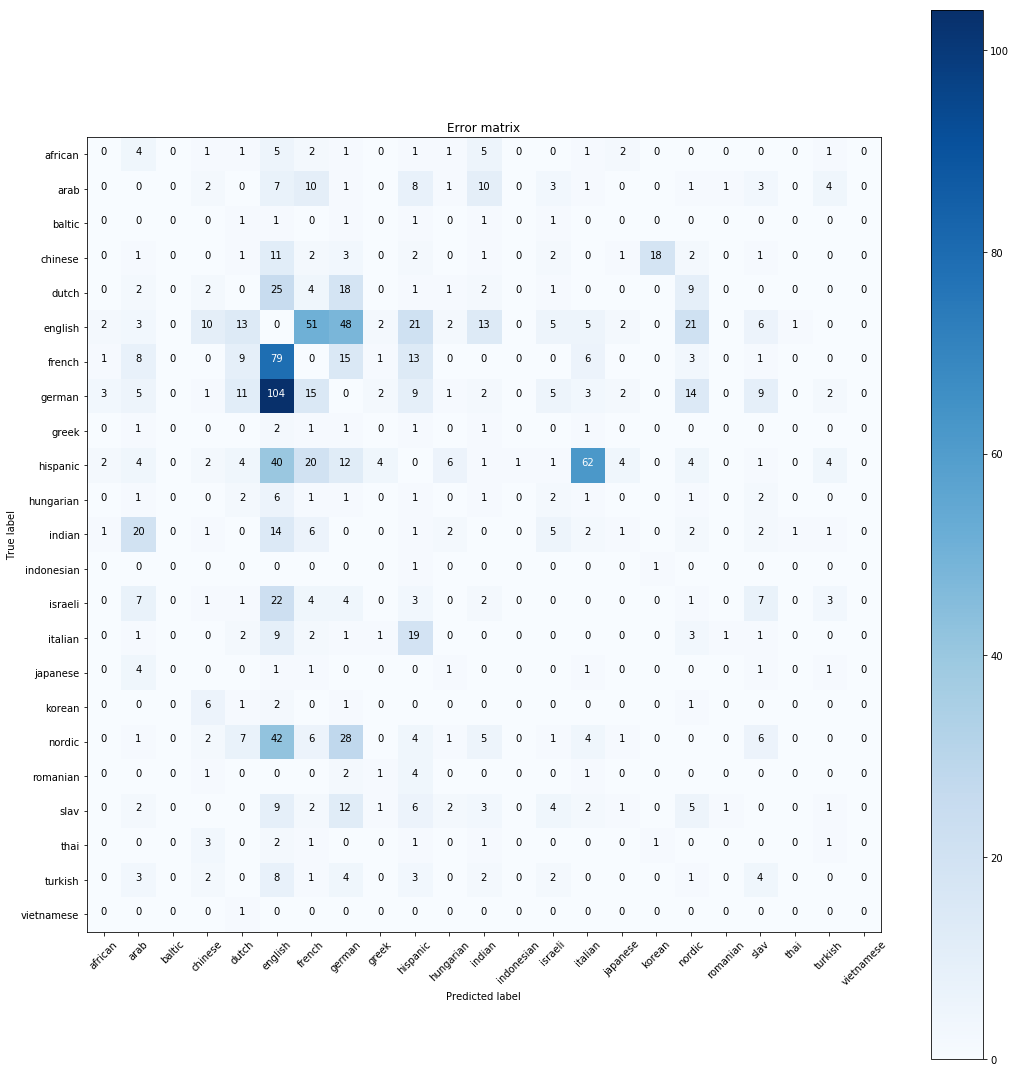

In [32]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True value')
    plt.xlabel('Predicted value')

# Compute confusion matrix
cnf_matrix = confusion_matrix(predicting_error, class_error)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=ethnic_keys,
                      title='Error matrix')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=ethnic_keys, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()